<a href="https://colab.research.google.com/github/omkarpat/EmpatheticDialoguesEmotionDetection/blob/master/Collapsed_Emotion_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab settings/mount
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My\ Drive/CSE\ 245\ Project
#check if drive is loaded successfully
!ls Data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/CSE 245 Project
'Data Exploration.ipynb'
 data_fixed_train_complement_analysis.csv
 data_fixed_train.json
 data_sample_100.json
 data_sample_10_complement_analysis.csv
 data_sample_10.json
 data_sample_10_processed.json
 data_sample_fixed_processed_final.json
 data_sample_fixed_processed_model1_final.csv
 data_sample_fixed_processed_model2_final.csv
 data_sample_fixed_processed_model3_final.csv
 data_sample_fixed_processed_model4_final.csv
 fixed
 fixed_test.csv
 fixed_test.json
 fixed_train_516.csv
 fixed_valid.csv
 fixed_valid.json
'informative words.ipynb'
 model1_predictions_test.csv
 model1_predictions_train.csv
 model1_predictions_valid.csv
 model2_predictions_test.csv
 model2_predictions_train.csv
 model2_predictions_valid.csv
 model3_predictions_test.csv
 model3_predictions_train.csv
 model3_predictions_valid.csv
 model4_pre

In [2]:
# install supporting libraries
!pip install transformers

In [3]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [27]:
dataset_name = "model4"
model_name = "model4"
model_type = "collapsed_emotion" #pos_neg or emotion or valence or collapsed_emotion

In [28]:
import pandas as pd
import numpy as np
train_filename = "Data/data_sample_fixed_processed_" + dataset_name + "_final.csv"
valid_filename = "Data/valid_fixed_processed_" + dataset_name + "_final.csv"
test_filename = "Data/test_fixed_processed_" + dataset_name + "_final.csv"

train_df = pd.read_csv(train_filename, sep='|', error_bad_lines=False)
train_df = train_df.dropna()
valid_df = pd.read_csv(valid_filename, sep='|', error_bad_lines=False)
valid_df = valid_df.dropna()
test_df = pd.read_csv(test_filename, sep='|', error_bad_lines=False)
test_df = test_df.dropna()

In [29]:
category2index = {
    "nostalgic":1,
    "sentimental":1,
    "sad":2,
    "devastated":2,
    "hopeful":3,
    "joyful":4,
    "impressed":5,
    "terrified":6,
    "afraid":6,
    "proud":7,
    "grateful":8,
    "lonely":9,
    "surprised":10,
    "anxious":11,
    "guilty":12,
    "trusting":13,
    "excited":15,
    "disgusted":16,
    "caring":17,
    "furious":18,
    "angry":18,
    "prepared":19,
    "disappointed":20,
    "faithful":21,
    "confident":22,
    "apprehensive":23,
    "jealous":24,
    "embarrassed":25,
    "annoyed":26,
    "ashamed":27,
    "content":28,
    "anticipating":29
}
index2category = {}
for key, value in category2index.items():
  index2category[value] = key

def category2label(category):
  for key in category2index.keys():
    if key == category:
      return category2index[key]
  print(category)
  return None

def label2emotion(labels):
  valence_list = []
  for label in labels:
    valence_list.append(index2category[label])
  return valence_list


In [30]:
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))
print('Number of valid sentences: {:,}\n'.format(valid_df.shape[0]))
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

train_df['label'] = train_df['emotion'].apply(lambda x: int(category2label(x.lower())))
valid_df['label'] = valid_df['emotion'].apply(lambda x: int(category2label(x.lower())))
test_df['label'] = test_df['emotion'].apply(lambda x: int(category2label(x.lower())))

# Display 10 random rows from the data.
train_df.sample(10)

Number of training sentences: 19,533

Number of valid sentences: 2,758

Number of test sentences: 2,538



,emotion,processed_emotion,text,vader_neg,vader_neu,vader_pos,vader_compound,textblob,flair_value,flair_confidence,label
828,surprised,positive,My girlfriend secretly booked a cruise for us...,0.00,0.77,0.23,0.89,-7.93e-18,POSITIVE,0.97,10
6407,caring,positive,i loved taking care of my sisters pet i loved ...,0.14,0.50,0.36,0.87,4.19e-01,NEGATIVE,0.99,17
5833,impressed,positive,I am very surprised by the performances of the...,0.07,0.80,0.13,0.53,1.20e-01,POSITIVE,1.00,5
11551,content,positive,I am happy with my life right now_comma_ every...,0.09,0.59,0.32,0.99,4.25e-01,POSITIVE,0.96,28
8349,anxious,negative,I have to get surgery tomorrow morning. I am g...,0.14,0.73,0.13,0.18,-2.16e-01,POSITIVE,1.00,11
11909,embarrassed,negative,thinking someone was talking to me when they w...,0.05,0.86,0.09,0.47,2.30e-01,NEGATIVE,0.87,25
5290,lonely,negative,My girlfriend left me last week. I miss her so...,0.16,0.68,0.16,-0.06,-3.67e-02,NEGATIVE,0.84,9
18046,lonely,negative,I feel so alone these days I feel so alone the...,0.10,0.72,0.18,0.57,1.36e-01,POSITIVE,1.00,9
10264,apprehensive,negative,I really love a good scare_comma_ but I'm also...,0.19,0.54,0.27,0.93,2.90e-01,POSITIVE,0.93,23
5762,sad,negative,My favorite steak and cheese place is closing ...,0.06,0.73,0.21,0.81,1.66e-01,POSITIVE,1.00,2


In [31]:
sentences_train = train_df.text.values
labels_train = train_df.label.values
sentences_valid = valid_df.text.values
labels_valid = valid_df.label.values
sentences_test = test_df.text.values
labels_test = test_df.label.values

In [32]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [33]:
# Print the original sentence.
print(' Original: ', sentences_train[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences_train[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences_train[0])))

 Original:  I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world. I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people_comma_ we felt like the only people in the world. Was this a friend you were in love with_comma_ or just a best friend? This was a best friend. I miss her. Where has she gone? We no longer talk. Oh was this something that happened because of an argument?
Tokenized:  ['i', 'remember', 'going', 'to', 'the', 'fireworks', 'with', 'my', 'best', 'friend', '.', 'there', 'was', 'a', 'lot', 'of', 'people', '_', 'com', '##ma', '_', 'but', 'it', 'only', 'felt', 'like', 'us', 'in', 'the', 'world', '.', 'i', 'remember', 'going', 'to', 'see', 'the', 'fireworks', 'with', 'my', 'best', 'friend', '.', 'it', 'was', 'the', 'first', 'time', 'we', 'ever', 'spent', 'time', 'alone', 'together', '.', 'although', 'there', 'wa

In [34]:
longer_list = []
for index, sent in enumerate(sentences_train):
  if len(tokenizer.encode(sent, add_special_tokens=True)) > 500:
    longer_list.append(index)
sentences_train = np.delete(sentences_train, longer_list)
labels_train = np.delete(labels_train, longer_list)

max_len = 0
# For every sentence...
for sent in sentences_train:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max train sentence length: ', max_len)

max_len = 0
# For every sentence...
for sent in sentences_valid:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max valid sentence length: ', max_len)

max_len = 0
# For every sentence...
for sent in sentences_test:
    try:
      # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
      input_ids = tokenizer.encode(sent, add_special_tokens=True)
    except:
      print(sent)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max test sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (554 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors


Max train sentence length:  432
Max valid sentence length:  489
Max test sentence length:  442


In [37]:
def tokenize(sentences, labels):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.

      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          truncation = 'only_first',
                          max_length = 512,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.from_numpy(labels)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', sentences[0])
  print('Token IDs:', input_ids[0])
  return(input_ids, attention_masks, labels)

In [36]:
input_ids_train, attention_masks_train, labels_train = tokenize(sentences_train, labels_train)
input_ids_valid, attention_masks_valid, labels_valid = tokenize(sentences_valid, labels_valid)
input_ids_test, attention_masks_test, labels_test = tokenize(sentences_test, labels_test)

Original:  I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world. I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people_comma_ we felt like the only people in the world. Was this a friend you were in love with_comma_ or just a best friend? This was a best friend. I miss her. Where has she gone? We no longer talk. Oh was this something that happened because of an argument?
Token IDs: tensor([  101,  1045,  3342,  2183,  2000,  1996, 16080,  2007,  2026,  2190,
         2767,  1012,  2045,  2001,  1037,  2843,  1997,  2111,  1035,  4012,
         2863,  1035,  2021,  2009,  2069,  2371,  2066,  2149,  1999,  1996,
         2088,  1012,  1045,  3342,  2183,  2000,  2156,  1996, 16080,  2007,
         2026,  2190,  2767,  1012,  2009,  2001,  1996,  2034,  2051,  2057,
         2412,  2985,  2051,  2894,  2362,  1012,  2348

In [38]:

from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_valid = TensorDataset(input_ids_valid, attention_masks_valid, labels_valid)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset_train))
val_size = len(dataset_train) - train_size

# Divide the dataset by randomly selecting samples.
#train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#Use the given training and validation datasets
train_dataset, val_dataset = dataset_train, dataset_valid

print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))

19,530 training samples
2,758 validation samples


In [39]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [40]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 30, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [41]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [42]:
import random
import numpy as np
from transformers import get_linear_schedule_with_warmup

def train(dataloader, epochs=5):
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

  # Number of training epochs. The BERT authors recommend between 2 and 4. 
  # We chose to run for 4, but we'll see later that this may be over-fitting the
  # training data.
  #epochs = 15

  # Total number of training steps is [number of batches] x [number of epochs]. 
  # (Note that this is not the same as the number of training samples).
  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)

  # Set the seed value all over the place to make this reproducible.
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # We'll store a number of quantities such as training and validation loss, 
  # validation accuracy, and timings.
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  # For each epoch...
  for epoch_i in range(0, epochs):
      
      # ========================================
      #               Training
      # ========================================
      
      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      # Put the model into training mode. Don't be mislead--the call to 
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(dataloader):

          # Progress update every 40 batches.
          if step % 40 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(dataloader), elapsed))

          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the 
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because 
          # accumulating the gradients is "convenient while training RNNs". 
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
          model.zero_grad()        

          # Perform a forward pass (evaluate the model on this training batch).
          # The documentation for this `model` function is here: 
          # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
          # It returns different numbers of parameters depending on what arguments
          # arge given and what flags are set. For our useage here, it returns
          # the loss (because we provided labels) and the "logits"--the model
          # outputs prior to activation.
          loss, logits = model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask, 
                              labels=b_labels)

          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value 
          # from the tensor.
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)            
      
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epoch took: {:}".format(training_time))
          
      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables 
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in validation_dataloader:
          
          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using 
          # the `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():        

              # Forward pass, calculate logit predictions.
              # token_type_ids is the same as the "segment ids", which 
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              # The documentation for this `model` function is here: 
              # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
              # Get the "logits" output by the model. The "logits" are the output
              # values prior to applying an activation function like the softmax.
              (loss, logits) = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
              
          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)
          

      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)
      
      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)
      
      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  return model, training_stats
model, training_stats = train(train_dataloader)


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    611.    Elapsed: 0:00:30.
  Batch    80  of    611.    Elapsed: 0:01:00.
  Batch   120  of    611.    Elapsed: 0:01:29.
  Batch   160  of    611.    Elapsed: 0:01:59.
  Batch   200  of    611.    Elapsed: 0:02:29.
  Batch   240  of    611.    Elapsed: 0:02:59.
  Batch   280  of    611.    Elapsed: 0:03:29.
  Batch   320  of    611.    Elapsed: 0:03:58.
  Batch   360  of    611.    Elapsed: 0:04:28.
  Batch   400  of    611.    Elapsed: 0:04:58.
  Batch   440  of    611.    Elapsed: 0:05:28.
  Batch   480  of    611.    Elapsed: 0:05:57.
  Batch   520  of    611.    Elapsed: 0:06:27.
  Batch   560  of    611.    Elapsed: 0:06:57.
  Batch   600  of    611.    Elapsed: 0:07:27.

  Average training loss: 2.08
  Training epoch took: 0:07:35

Running Validation...
  Accuracy: 0.62
  Validation Loss: 1.32
  Validation took: 0:00:21

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    611.    Elapsed: 0:00:30.
  Batch  

In [43]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,2.08,1.32,0.62,0:07:35,0:00:21
2,1.12,1.15,0.66,0:07:35,0:00:21
3,0.83,1.12,0.66,0:07:35,0:00:21
4,0.66,1.15,0.66,0:07:35,0:00:21
5,0.56,1.16,0.66,0:07:35,0:00:21


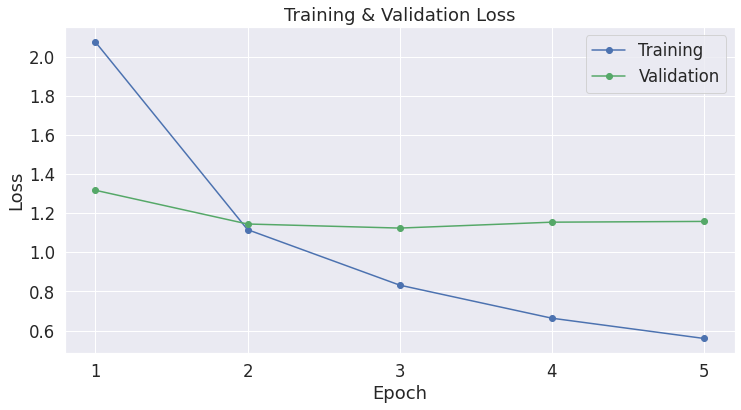

In [44]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

In [45]:
def predict(dataset):

  # Create the DataLoader for  dataset.
  prediction_data = dataset
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


  # Prediction on test set

  print('Predicting labels for {:,} sentences...'.format(len(dataset)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []

  # Predict 
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

  print('DONE.')
  return predictions, true_labels

test_predictions, test_true_labels = predict(dataset_test)
valid_predictions, valid_true_labels = predict(dataset_valid)
train_predictions, train_true_labels = predict(dataset_train)

Predicting labels for 2,538 sentences...
DONE.
Predicting labels for 2,758 sentences...
DONE.
Predicting labels for 19,530 sentences...
DONE.


In [46]:
from sklearn.metrics import classification_report, accuracy_score

def metrics(predictions, true_labels):
  for i in range(len(predictions)):
    if i == 0:
      pred_flat = np.argmax(predictions[i], axis=1).flatten()
      confidence_flat = np.amax(predictions[i], axis=1).flatten()
      labels_flat = true_labels[i].flatten()
    else:
      pred_flat = np.append(pred_flat, np.argmax(predictions[i], axis=1).flatten())
      confidence_flat = np.append(confidence_flat, np.amax(predictions[i], axis=1).flatten())
      labels_flat = np.append(labels_flat, true_labels[i].flatten())

  print(len(pred_flat), len(labels_flat))
  pred_flat = label2emotion(pred_flat)
  labels_flat = label2emotion(labels_flat)
  print(classification_report(labels_flat, pred_flat))
  print(accuracy_score(labels_flat, pred_flat))
  return pred_flat, confidence_flat
pred_flat_test, confidence_flat_test = metrics(test_predictions, test_true_labels)
pred_flat_valid, confidence_flat_valid = metrics(valid_predictions, valid_true_labels)
pred_flat_train, confidence_flat_train = metrics(train_predictions, train_true_labels)

2538 2538
              precision    recall  f1-score   support

      afraid       0.72      0.80      0.76       144
       angry       0.73      0.62      0.67       151
     annoyed       0.63      0.60      0.62        91
anticipating       0.50      0.39      0.44        72
     anxious       0.51      0.58      0.54        78
apprehensive       0.47      0.38      0.42        71
     ashamed       0.29      0.22      0.25        64
      caring       0.69      0.79      0.74        80
   confident       0.63      0.72      0.67        75
     content       0.82      0.70      0.75        76
  devastated       0.70      0.76      0.73       155
disappointed       0.61      0.63      0.62        81
   disgusted       0.77      0.87      0.82        85
 embarrassed       0.76      0.83      0.79        81
     excited       0.51      0.55      0.53        91
    faithful       0.73      0.66      0.69        50
    grateful       0.64      0.67      0.66        95
      guilty     

In [47]:

import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
 
output_dir = './basic_collapsed_emotion_model4_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./basic_collapsed_emotion_model4_save/


('./basic_collapsed_emotion_model4_save/vocab.txt',
 './basic_collapsed_emotion_model4_save/special_tokens_map.json',
 './basic_collapsed_emotion_model4_save/added_tokens.json')